In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import en_core_web_md
import csv
import regex as re
import os
import nltk
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict
from textblob import TextBlob
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
import readability
import pprint # pretty print for easy printing of ordered dictionary
# import spacy # Needed for GeeksforGeeks code which is a mess
from textstat.textstat import textstatistics
import spacy
spacy.load('en_core_web_md')
from nltk.corpus import cmudict
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download ('wordnet')
import unicodedata
import stanza
word_token = TreebankWordTokenizer()

[nltk_data] Downloading package punkt to /home/muddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/muddy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<A HREF="https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf">Pandas cheat sheet</A>

In [47]:
file='speech_and_date.csv'
dates=pd.read_csv(file)
dates['date'][23]

'10/05/2010'

In [72]:
# use .iloc[0] to get the actual string in the cell and not a pandas object
dates.loc[dates['date'] == '27/01/2010']['file'].iloc[0]

'DataUCSB/address-before-joint-session-the-congress-the-state-the-union-17.txt'

In [83]:
# use .iloc[0] to get the actual string in the cell and not a pandas object
speechlink = dates.loc[dates['date'] == '27/01/2010']['file'].iloc[0]
with open(speechlink, encoding='utf-8') as f:
        spec_speech = f.read()
spec_speech=re.sub('\[.+?\]', '',spec_speech)
spec_speech=re.sub('\-\-', ' ',spec_speech)

In [81]:
nytimesFile="./NYTimes/01-27-2010.txt"
with open(nytimesFile, encoding='utf-8') as f:
        nytimes = f.read()
nytimes = nytimes.replace('\n', '')

In [9]:
# Load up the files
path = './DataUCSB/'
list_of_files = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.txt'):
            list_of_files.append(os.path.join(root,file))

speeches = []
for file in list_of_files:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    speeches.append(text)

<A HREF="https://regexr.com/">Regexr</A>

In [10]:
# take out stuff like [Laughter] and [applause] and [Obama signs document]
speeches = [re.sub('\[.+?\]', '',speech) for speech in speeches]
# take out -- between words and replace with a space
speeches = [re.sub('\-\-', ' ',speech) for speech in speeches]

Just looking at the one specific Obama speech vs NYTimes article here, not all

In [84]:
speechlist_ob = [sentence.lstrip().rstrip() for sentence in spec_speech.split('.')]
lengthsob = [len(sentence.split(' ')) for sentence in speechlist_ob]

Rem: NYTimes article is filled with many quotes from Obama's speech

In [85]:
speechlist_ny = [sentence.lstrip().rstrip() for sentence in nytimes.split('.')]
lengthsny = [len(sentence.split(' ')) for sentence in speechlist_ny]

<A HREF="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html">Matplotlib docs</A>

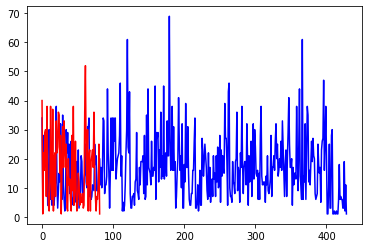

In [86]:
plt.plot(lengthsob, 'b')
plt.plot(lengthsny, 'r')
plt.show()

In [89]:
print('Obama: mean %s and stdev %s' %(round(np.average(lengthsob),3), round(np.std(lengthsob),3)))

Obama: mean 16.888 and stdev 10.962


In [90]:
print('NYTines: mean %s and stdev %s' %(round(np.average(lengthsny),3), round(np.std(lengthsny),3)))

NYTines: mean 16.561 and stdev 12.211


<A HREF="https://matplotlib.org/stable/gallery/statistics/hist.html">Matplotlib histograms</A>

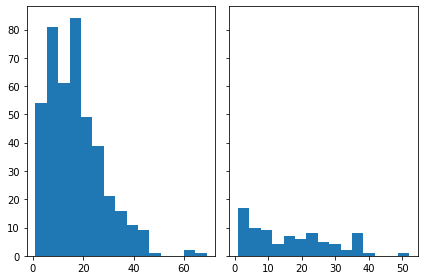

In [91]:
n_bins=15
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(lengthsob, bins=n_bins)
axs[1].hist(lengthsny, bins=n_bins)
plt.show()

<A HREF="https://datascience.stackexchange.com/questions/23376/how-to-get-the-number-of-syllables-in-a-word">Counting syllables</A>

In [17]:
def syllables(word):
    #referred from stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if count == 0:
        count += 1
    return count

<P>In a cmd/terminal window </P>
<P>>python</P>
<P>>>> import nltk</P>
<P>>>> nltk.download()</P>
<P>This opens a window from which you can download various corpora and dictionaries from NLTK</P>


In [19]:
import nltk
from nltk.corpus import cmudict
d = cmudict.dict()

In [20]:
def nsyl(word):
    try:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    except KeyError:
        #if word not found in cmudict
        return syllables(word)

<A HREF="https://spacy.io/universe/project/spacy_syllables">Spacy Syllables</A>

In [ ]:
!pip install spacy_syllables

In [23]:
import spacy
from spacy_syllables import SpacySyllables

In [24]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("syllables", after="tagger")

assert nlp.pipe_names == ["tok2vec", "tagger", "syllables", "parser",  "attribute_ruler", "lemmatizer", "ner"]
doc = nlp(speeches[87])
data = [(token.text, token._.syllables, token._.syllables_count) for token in doc]
# punctuation returns None, skip those
[i[2] for i in data if i[2]!=None]

/home/muddy/.local/lib/python3.9/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[1,
 3,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 4,
 1,
 5,
 4,
 1,
 2,
 1,
 4,
 1,
 5,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 4,
 2,
 1,
 3,
 2,
 1,
 5,
 1,
 3,
 4,
 1,
 4,
 1,
 2,
 1,
 5,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 5,
 1,
 3,
 1,
 3,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 5,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 3,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 2,
 1,
 1,
 2,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 3,
 1,
 2,
 3,
 3,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 2,
 3,
 2,
 1,
 1,
 5,
 1,
 2,
 2,
 1,
 3,
 5,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 4,
 1,


In [25]:
data

[('Good', ['good'], 1),
 ('afternoon', ['af', 'ter', 'noon'], 3),
 (',', None, None),
 ('everybody', ['ev', 'ery', 'body'], 3),
 ('.', None, None),
 ('Before', ['be', 'fore'], 2),
 ('Jay', ['jay'], 1),
 ('takes', ['takes'], 1),
 ('some', ['some'], 1),
 ('of', ['of'], 1),
 ('your', ['your'], 1),
 ('questions', ['ques', 'tions'], 2),
 (',', None, None),
 ('I', ['i'], 1),
 ('wanted', ['want', 'ed'], 2),
 ('to', ['to'], 1),
 ('provide', ['pro', 'vide'], 2),
 ('a', ['a'], 1),
 ('brief', ['brief'], 1),
 ('update', ['up', 'date'], 2),
 ('on', ['on'], 1),
 ('our', ['our'], 1),
 ('efforts', ['ef', 'forts'], 2),
 ('to', ['to'], 1),
 ('address', ['ad', 'dress'], 2),
 ('the', ['the'], 1),
 ('ongoing', ['on', 'go', 'ing'], 3),
 ('crisis', ['cri', 'sis'], 2),
 ('in', ['in'], 1),
 ('Ukraine', ['ukraine'], 1),
 ('.', None, None),
 ('Since', ['since'], 1),
 ('the', ['the'], 1),
 ('Russian', ['rus', 'sian'], 2),
 ('intervention', ['in', 'ter', 'ven', 'tion'], 4),
 (',', None, None),
 ('we', ['we'], 1),


## New stuff, count variance

In [109]:
oba = pd.read_csv('sentence_depth.csv')
oba = oba.query('source=="oba"')
gwb = pd.read_csv('sentence_depth_gwb.csv')

In [110]:
def words_per_sentence(sentence):
    '''returns: integer number of words in a sentence'''
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    return(len(tokens))

def syllable_count(word):
    '''backup syllable counter if word not in NLTK-CMU dictionary'''
    #referred from stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    try:
        if word[0] in vowels:
            count +=1
    except:
        count += 0
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if count == 0:
        count += 1
    return count

def chars_per_word(word):
    '''returns: integer number of characters in a word'''
    return(len(word))

d = cmudict.dict()
def nsyl(word):
    '''input: string - word
       returns: integer count of syllables in word'''
    try:
        # needs the [0] otherwise words like 'of' returns [1,1]
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]][0]
    except KeyError:
        #if word not found in cmudict
        return syllable_count(word)

In [111]:
oba['words_per_sent'] = oba.sentence.apply(words_per_sentence)
gwb['words_per_sent'] = gwb.sentence.apply(words_per_sentence)
oba['syllables_per_sent'] = [nsyl(word) for word in oba.sentence]
gwb['syllables_per_sent'] = [nsyl(word) for word in gwb.sentence]
oba['chars_per_sent'] = [chars_per_word(word) for word in oba.sentence]
gwb['chars_per_sent'] = [chars_per_word(word) for word in gwb.sentence]

In [112]:
oba.groupby(by='date').median(numeric_only=True)

,depth,words_per_sent,syllables_per_sent,chars_per_sent
date,,,,
2004-07-28,5.0,16.0,25.0,83.0
2008-06-04,6.0,23.0,35.0,125.0
2008-11-05,5.0,16.5,26.5,85.0
2009-01-05,6.0,18.5,31.0,110.5
2009-01-20,5.0,19.0,29.0,104.0
...,...,...,...,...
2016-07-28,4.0,14.0,19.5,70.5
2016-08-17,5.0,17.0,26.0,89.0
2016-09-05,5.0,18.0,30.0,107.5


In [113]:
gwb.groupby('date').mean(numeric_only=True)

,depth,words_per_sent,syllables_per_sent,chars_per_sent
date,,,,
2001-01-20,4.520833,16.687500,27.125000,92.875000
2001-01-22,4.666667,14.142857,22.666667,77.285714
2001-01-29,5.409836,17.459016,29.180328,100.180328
2001-02-16,7.470588,24.058824,43.823529,148.382353
2001-03-29,5.115385,15.923077,26.730769,91.846154
...,...,...,...,...
2008-09-04,4.290323,14.512903,21.316129,76.758065
2008-09-07,6.777778,26.888889,51.333333,172.333333
2008-10-01,5.666667,18.333333,34.666667,120.000000


In [161]:
top10.std(numeric_only=True)

depth                  2.720745
words_per_sent        15.170840
syllables_per_sent    23.818573
chars_per_sent        83.720235
dtype: float64

In [129]:
oba.std(numeric_only=True)

depth                  2.679265
words_per_sent        13.313618
syllables_per_sent    21.737954
chars_per_sent        75.727997
dtype: float64

In [130]:
gwb.std(numeric_only=True)

depth                  2.376683
words_per_sent        10.471476
syllables_per_sent    18.372897
chars_per_sent        62.817604
dtype: float64

In [116]:
variance_oba['sentence_count'] = oba.groupby(by='date').size()
variance_gwb['sentence_count'] = gwb.groupby(by='date').size()

In [117]:
oba_std = oba.groupby(by='date').std(numeric_only=True).add_suffix('_std')
gwb_std = gwb.groupby(by='date').std(numeric_only=True).add_suffix('_std')
oba.groupby(by='date').mean(numeric_only=True).add_suffix('_mean')
gwb.groupby(by='date').mean(numeric_only=True).add_suffix('_mean')
oba.groupby(by='date').median(numeric_only=True).add_suffix('_med')
gwb.groupby(by='date').median(numeric_only=True).add_suffix('_med')

,depth_med,words_per_sent_med,syllables_per_sent_med,chars_per_sent_med
date,,,,
2001-01-20,4.0,15.0,25.5,85.5
2001-01-22,4.0,12.0,18.0,63.0
2001-01-29,5.0,15.0,25.0,85.0
2001-02-16,7.0,22.5,42.0,144.0
2001-03-29,5.0,15.0,25.5,89.0
...,...,...,...,...
2008-09-04,4.0,12.0,18.0,67.0
2008-09-07,6.0,28.0,52.0,169.0
2008-10-01,6.0,20.0,40.0,131.5


In [118]:
oba.depth.std()

2.6792646674365406

In [119]:
gwb.depth.std()

2.376682583296076

In [120]:
oba.query('date == "2009-01-20"').words_per_sent.std()

15.514284981688279

In [121]:
fig = px.line(oba.query('date == "2009-01-20"').words_per_sent)
fig.show()

In [122]:
gwb.query('date == "2001-01-20"').words_per_sent.std()

7.780288859473156

In [126]:
fig = px.line(gwb.query('date == "2001-01-20"').words_per_sent)
fig.show()

In [124]:
tidy_oba = pd.read_csv('tidy_data_oba.csv')
tidy_gwb = pd.read_csv('tidy_data_gwb.csv')
tidy_oba = pd.merge(tidy_oba, oba_std, how='left', on='date')
tidy_gwb = pd.merge(tidy_gwb, gwb_std, how='left', on='date')

In [107]:
#tidy_oba.to_csv('tidy_data_oba.csv', index=False)
#tidy_gwb.to_csv('tidy_data_gwb.csv', index=False)

### Look at Top 10 speeches

In [134]:
# Load up the files
paths = ['./Top10/']
list_of_files = []

for path in paths:
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.txt'):
                list_of_files.append(os.path.join(root,file))

speeches = []
for file in list_of_files:
    with open(file, encoding='utf-8') as f:
        #print(file)
        text = f.read()
    f.close()
    speeches.append(text)

#clean out goofy unicode  space characters 
speeches = [unicodedata.normalize("NFKD", speech) for speech in speeches if len(speech)>0 ]

# remove [stuff] in between square brackets
def remove_bracket(text):
    return re.sub('(\[[^w]*\]\s)', '',text)
speeches = [remove_bracket(speech) for speech in speeches]

# lemmatize text with spacy
#nlp = spacy.load("en_core_web_md", exclude=["parser", "ner"])
#for i, doc in enumerate(nlp.pipe(speeches)):
#    words_lemmas_list = [token.lemma_ for token in doc]
#    speeches[i]= ' '.join(words_lemmas_list)
    
# Remove punctuation - only care about words here
#speeches = [re.sub(r'[^\w\s]', '', speech) for speech in speeches]

# remove numbers
#speeches = [re.sub(r'\d', '', speech) for speech in speeches]

# Clean up whitespace
speeches = [re.sub('[\s+]', ' ', speech) for speech in speeches]
    
# Combine speeches and filenames
speeches = list(zip(speeches, list_of_files))
    
def get_source(text):
    regex = "[^./][a-zA-Z]+[^/]"
    string = re.findall(regex, str(text))[0]
    if string == 'speeches': string = 'oba'
    if string == 'NYTimes': string = 'nyt'
    return string.lower()

def get_date(text):
    regex = "([0-9]+[\-][0-9]+[\-][0-9]+)"
    return re.findall(regex, str(text))[0]

def get_filename(text):
    regex = "[-]([a-zA-Z]+)"
    return re.findall(regex, str(text))[0]

#dates = pd.read_csv('speech_and_date.csv') # day-month-year
dates = pd.DataFrame(list_of_files, columns = ['filepath'])
dates['date'] = [get_date(file) for file in dates.filepath]
dates['date'] = pd.to_datetime(dates['date'], format='%Y-%m-%d')

cols_speeches = ['text', 'filepath']
text_df = pd.DataFrame(speeches, columns=cols_speeches)

text_df = pd.merge(text_df, dates, how='left', on='filepath')
text_df.sort_values(by='date')
text_df['source'] = text_df['filepath'].apply(get_source)
text_df.set_index('date', inplace=True)
text_df.head(3)

,text,filepath,source
date,,,
2015-06-26,Giving all praise and honor to God. The Bible ...,./Top10/2015-06-26-barackobamaclementapinckney...,top1
2009-06-04,Thank you so much. Good afternoon. I am honore...,./Top10/2009-06-04-barackobamacairouniversity.txt,top1
2004-07-28,"On behalf of the great state of Illinois, cros...",./Top10/2004-07-28-DNCSpeech.txt,top1


In [135]:
######################## HELPER FUNCTIONS ########################
def words_per_sentence(sentence):
    '''returns: integer number of words in a sentence'''
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    return(len(tokens))

def chars_per_word(word):
    '''returns: integer number of characters in a word'''
    return(len(word))

def string_to_list(sentence):
    '''converts a string/sentence to a list of words'''
    tokenizer = RegexpTokenizer(r'\w+')
    return(tokenizer.tokenize(sentence))

def chars_per_word_sentence(sentence):
    '''input: string of a sentence
       returns: list of number of characters in a sentence'''
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    char_len_list = [chars_per_word(word) for word in tokens]
    return(char_len_list)

def text_to_sentence(text):
    '''uses spacy nlp object to break up sentences
       input: pandas series of strings
       returns: list of sentence strings'''
    doc = nlp(' '.join(text.tolist()))
    assert doc.has_annotation("SENT_START")
    return([str(sent) for sent in doc.sents])

def text_to_wordlist(text):
    '''input: string or pandas series of text
       returns: list of all words'''
    if isinstance(text, str):
        text = [text]
    return(' '.join(text).split())

def syllable_count(word):
    '''counts number of syllables in a word'''
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

def count_total_words(text):
    '''count total number of words in a text
       input: str or pandas.core.series.Series of text
       returns: integer'''
    if isinstance(text, list):
        list_of_sentence = text
    elif isinstance(text, str):
        list_of_sentence = [text]
    elif isinstance(text, pd.Series):
        list_of_sentence = text_to_sentence(text)
    else:
        print('count_total_words: Error: not a string or pandas series object.')
    list_of_word_count = [words_per_sentence(str(sentence)) for sentence in list_of_sentence]
    return(np.sum(list_of_word_count))

def count_total_sentences(text):
    '''count total number of sentences in a text
       input: str or pandas.core.series.Series of text
       returns: integer'''
    if isinstance(text, pd.Series):
        text = ' '.join(text)
    sentences = sent_tokenize(text)
    return(len(sentences))

# Count Syllables
# https://datascience.stackexchange.com/questions/23376/how-to-get-the-number-of-syllables-in-a-word
def syllables(word):
    '''backup syllable counter if word not in NLTK-CMU dictionary'''
    #referred from stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    try:
        if word[0] in vowels:
            count +=1
    except:
        count += 0
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if count == 0:
        count += 1
    return count

d = cmudict.dict()
def nsyl(word):
    '''input: string - word
       returns: integer count of syllables in word'''
    try:
        # needs the [0] otherwise words like 'of' returns [1,1]
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]][0]
    except KeyError:
        #if word not found in cmudict
        return syllables(word)

def count_total_syllables(text):
    '''count total number of sentences in a text
       input: str or pandas.core.series.Series of text
       returns: integer count'''
    if isinstance(text, str):
        list_of_sentence = [text]
    elif isinstance(text, pd.Series):
        list_of_sentence = text_to_sentence(text)
    else:
        print('count_total_syllables: Error: not a string or pandas series object.')
    list_of_words = text_to_wordlist(list_of_sentence)
    syllable_list = [nsyl(word) for word in list_of_words]
    return(np.sum(syllable_list))

def count_of_letters(text):
    '''count total number of letters or digits in a text
       input: str or pandas.core.series.Series of text
       returns: integer count'''
    if isinstance(text, pd.Series):
        text = ' '.join(text)
    # Replace punctuations with an empty string.
    str1 = re.sub(r"[^\w\s]|_", "", text)
    no_spaces = str1.replace(" ", "")
    return(len(no_spaces))


def difficult_words_list(list1):
    '''returns difference of list with easy_word list for Dale-Chall
       input: two lists of strings/words
       returns: list of unique words in both lists'''
    if isinstance(list1, pd.Series):
        list1 = ' '.join(text)
    if isinstance(list1, list):
        list1 = list1[0]
    try:
        easy_words_file = open('./word_lists/DaleChallEasyWordList.txt', 'r')
        easy_words = easy_words_file.read().split('\n')
    except E:
        print("Error reading easy words file", E)
    easy_words_file.close()
    easy_words = [word.lower() for word in easy_words]
    easy_words = set(easy_words)
    diff = [word.lower() for word in list1.split() if word.lower() not in easy_words]
    return(diff)

def dc_difficult_word_count(text):
    '''Count of difficult words - those not in Dale-Chall Easy Word List
       input: str or pandas.core.series.Series of text
       returns: integer count of difficult words in text'''
    list_of_dc_difficult = difficult_words_list(text)
    return(len(list_of_dc_difficult))

lemmatizer = WordNetLemmatizer()
def gf_complex_word_count(text):
    '''Count of complex - >= 3 syllables with caveats
       input: str or pandas.core.series.Series of text
       returns: integer count of complex words in text'''
    if isinstance(text, pd.Series):
        text = ' '.join(text)
    if isinstance(text, list):
        text = str(text[0])
    text = [word.lower() for word in text.split()]
    lemma = [lemmatizer.lemmatize(word) for word in text]
    stem = [re.sub("(?:ing|ed|es|ly)$","",word) for word in text]
    syllable_list = [nsyl(word) for word in stem]
    complex_count = sum(x > 2 for x in syllable_list)
    return(complex_count)

def smog_poly_count(text):
    '''counts number of words with 3 or more syllables
       input: str or pandas.core.series.Series of text
       returns: integer count of polysyllabic words in text'''
    if isinstance(text, pd.Series):
        text = ' '.join(text)
    if isinstance(text, list):
        text = str(text[0])
    text = [word.lower() for word in text.split()]
    syllable_list = [nsyl(word) for word in text]
    poly_count = sum(x > 2 for x in syllable_list)
    return(poly_count)


######################## READABILITY SCORES ########################

# https://en.wikipedia.org/wiki/Automated_readability_index
# 4.71(chars/word) + 0.5(words/sentence) - 21.43
def ari(text):
    '''input: string of sentence
       returns: float ari score'''
    character_count = count_of_letters(text)
    word_count = count_total_words(text)
    sentence_count = count_total_sentences(text)
    ari = 4.71*(character_count/word_count) + 0.5*(word_count/sentence_count) - 21.43
    return(ari)

# https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
# Flesch–Kincaid grade level
# 0.39(total words/total sentences) + 11.8(total syllables/total words) - 15.59
def flesch_kincaid(text):
    '''input: string or pandas series of text, multiple sentences
       returns: float - flesh kincaid grade level score'''
    num_total_words = count_total_words(text)
    num_total_sentences = count_total_sentences(text)
    num_total_syllables = count_total_syllables(text)
    fkgl = 0.39*(num_total_words/num_total_sentences) + 11.8*(num_total_syllables/num_total_words) - 15.59
    return(fkgl)

# https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index
# 0.0588(average number of letters per 100 words) - 0.296(average number of sentences per 100 words) - 15.8
def coleman_liau(text):
    '''input: string or pandas series of text, multiple sentences
       returns: float - Coleman-Liau index'''
    character_count = count_of_letters(text)
    word_count = count_total_words(text)
    sentence_count = count_total_sentences(text)
    l = character_count/word_count*100
    s = sentence_count/word_count*100
    cl = 0.0588*l - 0.296*s - 15.8
    return(cl)

# https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula
# 0.1579(100*difficult words/words) + 0.496(words/sentences)
def dale_chall(text):
    '''input: string or pandas series of text, multiple sentences
       returns: float - Dale-Chall readability score'''
    difficult_words = dc_difficult_word_count(text)
    word_count = count_total_words(text)
    sentence_count = count_total_sentences(text)
    dc = 0.1579*(100*difficult_words/word_count) + 0.496*(word_count/sentence_count)
    return(dc)

# https://en.wikipedia.org/wiki/Gunning_fog_index
# 0.4[(words/sentence) + 100(complex words/words)]
def gunning_fog(text):
    '''input: string or pandas series of text, multiple sentences
       returns: float - Gunning Fog index readability score'''
    complex_words = gf_complex_word_count(text)
    word_count = count_total_words(text)
    sentence_count = count_total_sentences(text)
    gf = 0.4*((word_count/sentence_count) + 100*(complex_words/word_count))
    return(gf)

# https://en.wikipedia.org/wiki/SMOG
# 1.043*sqrt(30*number polysylables/number sentences)+3.1291
def smog(text):
    '''input: string or pandas series of text, multiple sentences
       returns: float - SMOG grade readability score'''
    poly_count = smog_poly_count(text)
    sentence_count = count_total_sentences(text)
    smog_score = 1.043*np.sqrt(30*poly_count/sentence_count) + 3.1291
    return(smog_score)

In [136]:
text_df['char_count'] = text_df['text'].apply(count_of_letters)
text_df['syl_count'] = text_df['text'].apply(count_total_syllables)
text_df['word_count'] = text_df['text'].apply(count_total_words)
text_df['char_per_word'] = text_df['char_count']/text_df['word_count']#
text_df['syl_per_word'] = text_df['syl_count']/text_df['word_count']#
text_df['sent_count'] = text_df['text'].apply(count_total_sentences)
text_df['word_per_sent'] = text_df['word_count']/text_df['sent_count']#

text_df['dc_word_count'] = text_df['text'].apply(dc_difficult_word_count)
text_df['gf_word_count'] = text_df['text'].apply(gf_complex_word_count)
text_df['poly_word_count'] = text_df['text'].apply(smog_poly_count)

text_df['dc_word_perc'] = text_df['dc_word_count']/text_df['word_count']#
text_df['gf_word_perc'] = text_df['gf_word_count']/text_df['word_count']#
text_df['poly_word_perc'] = text_df['poly_word_count']/text_df['word_count']#

text_df['ari'] = text_df['text'].apply(ari)
text_df['flesch_kincaid'] = text_df['text'].apply(flesch_kincaid)
text_df['coleman_liau'] = text_df['text'].apply(coleman_liau)
text_df['dale_chall'] = text_df['text'].apply(dale_chall)
text_df['gunning_fog'] = text_df['text'].apply(gunning_fog)
text_df['smog'] = text_df['text'].apply(smog)

In [142]:
nlp = stanza.Pipeline(lang='en', processors='tokenize')
doc = nlp('This is a test sentence for stanza. This is another sentence.')
print([sentence.text for sentence in doc.sentences])
for i, sentence in enumerate(doc.sentences):

2023-04-08 18:11:40 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-04-08 18:11:41 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2023-04-08 18:11:41 INFO: Using device: cpu
2023-04-08 18:11:41 INFO: Loading: tokenize
2023-04-08 18:11:41 INFO: Done loading processors!


['This is a test sentence for stanza.', 'This is another sentence.']


In [143]:
text_df['sentences'] = text_df['text'].apply(sent_tokenize)

In [151]:
text_df['date'] = text_df.index

In [152]:
# Make data frame of sentences and parse tree depth of each
def walk_tree_depth(node, depth):
    if node.n_lefts + node.n_rights > 0:
        return max(walk_tree_depth(child, depth+1) for child in node.children )
    else:
        return depth
nlp = spacy.load("en_core_web_md")    
tree_depth = pd.DataFrame(columns = ['date', 'source', 'sentence', 'depth'])
for i, speech in enumerate(text_df['sentences']):
    for j, sentence in enumerate(speech):
        doc = nlp(sentence)
        depth = [walk_tree_depth(sent.root, 0) for sent in doc.sents][0]
        tree_depth.loc[len(tree_depth)] = [text_df['date'].iloc[i], text_df['source'].iloc[i], sentence, depth]

In [154]:
tree_depth['words_per_sent'] = tree_depth.sentence.apply(words_per_sentence)
tree_depth['syllables_per_sent'] = [nsyl(word) for word in tree_depth.sentence]
tree_depth['chars_per_sent'] = [chars_per_word(word) for word in tree_depth.sentence]

In [155]:
tree_depth.groupby(by='date').std(numeric_only=True).add_suffix('_std')

,depth_std,words_per_sent_std,syllables_per_sent_std,chars_per_sent_std
date,,,,
2004-07-28,2.844063,21.525296,31.405842,112.610653
2008-03-18,3.022116,17.011296,28.029918,96.685098
2008-08-28,2.752099,16.350835,24.926814,87.917105
2008-11-04,3.066697,19.629516,29.506903,106.358513
2009-06-04,2.300584,11.922056,19.856574,68.133230
2009-10-09,2.690526,11.425525,18.887673,65.597751
2011-01-14,2.695232,14.291677,21.541347,76.207387
2015-03-07,2.139607,12.979018,20.470547,73.642031
2015-06-26,2.870117,15.717180,25.220822,89.114615


In [157]:
tree_depth.groupby(by='date').median(numeric_only=True).add_suffix('_med')

,depth_med,words_per_sent_med,syllables_per_sent_med,chars_per_sent_med
date,,,,
2004-07-28,5.0,16.0,25.0,83.0
2008-03-18,6.0,21.0,33.0,113.0
2008-08-28,5.0,20.0,29.0,105.0
2008-11-04,5.0,16.0,26.0,81.0
2009-06-04,5.0,17.0,28.0,98.0
2009-10-09,5.0,18.5,30.0,103.0
2011-01-14,5.0,17.0,26.0,87.0
2015-03-07,5.0,16.0,24.0,86.5
2015-06-26,4.0,11.0,17.0,60.0


In [158]:
fig = px.line(tree_depth.query('date == "2008-03-18"').words_per_sent)
fig.show()